<a href="https://colab.research.google.com/github/markliyx/jail_management_market_analysis/blob/main/Prison_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Which prisons have the most inefficient prison management structure? 
## --- A study of the 2005 US Census of State and Federal Adult Correctional Facilities

**Annotated Market Analysis Notebook 
MTX Group Investment Analyst by Mark Li \\
Updated as of June 30th, 2021** 


## Introducton

In this notebook, I'll do some basic EDA to have a sense of what the US prison market is like, filtering and highlighting some key variables. I have stated my assumption of the targeted consumer profile in the market analysis research notebook before. In this notebook, I'll work with the aforementioned assumptions: \\
Let **inefficient prison management** be simplified as a management structure that promotes inmate and staff assaults. From the study, these features showed significant positive correlations: **black-to-white guard ratio**, **institutional size** (defined as average daily population), and **prison security**.

Thus, from the above description, inefficient prison management have low black-to-white gaurd ratio, high institutional size, and high prison security. 

I got my data from the \\
Census of State and Federal Adult Correctional Facilities, 2005 (ICPSR 24642)\\
https://www.icpsr.umich.edu/web/NACJD/studies/24642#

*This census is the seventh enumeration of state adult correctional institutions and the fourth of federal institutions sponsored by the Bureau of Justice Statistics and conducted by the Bureau of the Census. Earlier censuses were completed in 1979 (ICPSR 7852), 1984 (ICPSR 8444), 1990 (ICPSR 9908), 1995 (ICPSR 6953), and 2000 (ICPSR 4021). For each facility, information was provided on physical security, age, functions, capacity, court orders for specific conditions, one-day counts and average populations, race/ethnicity of inmates, inmate work assignments, inmate deaths, special inmate counts, assaults, and incidents caused by inmates.*

# Setup, Imports, and Data Loading
Setting up the nessary packages/ libraries and readin the .dta file in Python. 

The prison dataset consists of 366 variables for 1,821 prisons in US. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [107]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt 
import os 
import statsmodels.formula.api as smf 
import sklearn 
import plotly.express as px
from sklearn import tree 
from sklearn.model_selection import train_test_split 

#reading dta file 
prison_data = pd.read_stata('/content/prison_market_analysis_data/prison_data.dta')
prison_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V39F,...,V203,V204,V204F,V205,V205F,V206,V207,V208,V209,V210,V210S,V211,V212,V212F,V213,V214,V214F,V215,V216,V217,V218,V219,V220,V221,V222,V223,V223S,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V233S,V234,V235
0,010000000070100000000,KILBY CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,P. O. BOX 150,MT. MEIGS,AL,36057.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,Yes,Yes,No,No,No,No,No,No,No,Yes,PRISON INDUSTRY,1,None,0,Don't know,...,Yes,0,Actual,Missing,Don't know,No,Yes,No,No,No,,No,Missing,Actual,No,Missing,Actual,Yes,Yes,Yes,No,No,No,No,No,Yes,NOT SPECIFIED,No,Yes,Yes,Yes,No,No,Yes,Yes,No,Yes,MENTAL HEALTH PROGRAM,No,MONTGOMERY COUNTY
1,010000000070200000000,W C HOLMAN CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,HOLMAN 3700,ATMORE,AL,365033700.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,Yes,0,Actual,Missing,Don't know,Yes,No,No,No,No,,No,Missing,Actual,No,Missing,Actual,No,No,Yes,No,No,Yes,No,No,No,,No,Yes,Yes,Yes,No,No,No,Yes,No,No,,No,ESCAMBIA COUNTY
2,010000000070300000000,DRAPER CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,P. O. BOX 1107,ELMORE,AL,36025.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Medium,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,No,Missing,Actual,Missing,Don't know,Yes,Yes,Yes,No,No,,No,Missing,Actual,No,Missing,Actual,Yes,Yes,Yes,No,No,Yes,No,No,No,,No,Yes,Yes,No,No,Yes,No,Yes,No,No,,No,ELMORE COUNTY
3,010000000070400000000,JULIA TUTWILER PRISON,,,,MONTGOMERY,AL,36130,8966 US HWY 231 N,WETUMPKA,AL,36092.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Female,Maximum/close/high,,Yes,No,No,Yes,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,Yes,2,Actual,Missing,Don't know,Yes,No,No,No,No,,No,Missing,Actual,No,Missing,Actual,No,No,No,No,No,Yes,No,No,No,,No,Yes,No,Yes,No,No,No,No,Yes,No,,No,ELMORE COUNTY
4,010000000070500000000,FRANK LEE YOUTH CENTER,,,,MONTGOMERY,AL,36130,P. O. BOX 220410,DEATSVILLE,AL,36022.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Minimum/low,,Yes,No,No,No,No,No,No,No,Yes,No,No,,9,None,Missing,Not applicable,...,Yes,0,Actual,Missing,Don't know,Yes,Yes,No,No,No,,No,Missing,Actual,No,Missing,Actual,No,No,Yes,No,No,Yes,No,No,No,,No,Yes,Yes,No,No,No,No,No,No,No,,No,ELMORE COUNTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,510000000070300000000,WYOMING HONOR FARM,,,,CHEYENNE,WY,82002,40 HONOR FARM ROAD,RIVERTON,WY,82501.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Minimum/low,,Yes,No,No,Yes,No,No,No,No,No,No,No,,1,None,250,Actual,...,No,Missing,Actual,0,Actual,No,Yes,Yes,Yes,No,,No,227,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,,No,FREMONT COUNTY
1817,510000000070400000000,WYOMING HONOR CONSERVATION CAMP & BOOT CAMP,,,,CHEYENNE,WY,82002,P. O. BOX 160,NEWCASTLE,WY,82701.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Minimum/low,,Yes,No,No,Yes,No,No,Yes,No,No,No,No,,1,50% or more of the inmates,222,Actual,...,Yes,0,Actual,0,Actual,No,Yes,Yes,Yes,No,,No,157,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,,No,WESTON COUNTY
1818,518000000070500000000,COMM ALTERNATIVES OF CASPER & RE-ENTRY CTR,,,,MILLS,WY,826442380,PO BOX 2380,MILLS,WY,82644.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,Private,Both,Minimum/low,SECURE SECTION-MED SECURITY,No,Yes,No,No,No,Yes,No

In [6]:
prison_data.dtypes

V1         object
V2         object
V3         object
V4         object
V5         object
           ...   
V232     category
V233     category
V233S      object
V234     category
V235       object
Length: 366, dtype: object

# EDA
First off, I will find out the standard deviations, range, and do basic categorization of the prisons. 

First part of EDA explores institutional size. There are a couple of parameters that can be used as indicators for institutional size. These include: \\
V37 - largest # of inmates \\
V78 - inmate total \\
V98 - total inmate on 12/30/2005 \\
V102 - total inmate on 12/30/2005 \\


In [45]:
# find out the standard devaiton and mean of the institutional size of the prisons
# V78 is inmate total
new_prison_data = prison_data[prison_data['V78'] != 'Missing']
new_prison_data['V78'].count()
new_prison_data['V78'].dtypes

CategoricalDtype(categories=[        0,         4,         6,         7,         8,
                         10,        11,        12,        13,        14,
                  ...
                       5456,      5499,      5712,      6013,      6407,
                       6641,      7075,      7172,      7199, 'Missing'],
                 ordered=True)

In [48]:
prison_size_data = new_prison_data['V78'].cat.codes
prison_size_data.count()

1812

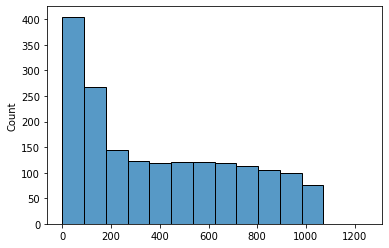

In [54]:
# plotting distribution of the largest # of inmates
prison_size_data = prison_size_data.rename({'V78': 'inmate total'})
sns.histplot(data=prison_size_data, palette='husl', multiple="stack", binrange = (0, 1250))


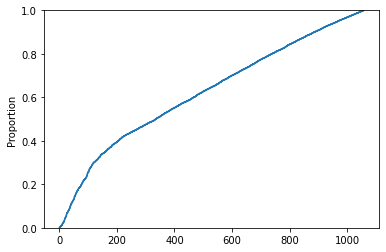

In [55]:
# plotting a boxplot of the prison_size_data
sns.ecdfplot(data=prison_size_data,palette='husl')

In [12]:
# drop missing values
prison_gaurd_ratio_data = prison_data[['V177', 'V179']]
prison_gaurd_ratio_data = prison_gaurd_ratio_data[prison_gaurd_ratio_data['V177'] != 'Missing']
prison_gaurd_ratio_data.count()
prison_gaurd_ratio_data = prison_gaurd_ratio_data[prison_gaurd_ratio_data['V179'] != 'Missing']
prison_gaurd_ratio_data.count()

V177    1573
V179    1573
dtype: int64

In [13]:
# convert to int type
prison_gaurd_ratio_data['V179'] = prison_gaurd_ratio_data['V179'].cat.codes
prison_gaurd_ratio_data['V177'] = prison_gaurd_ratio_data['V177'].cat.codes
prison_gaurd_ratio_data.dtypes
prison_gaurd_ratio_data['V177'] = np.where(prison_gaurd_ratio_data['V177'] == 0, 0.1, prison_gaurd_ratio_data['V177'])

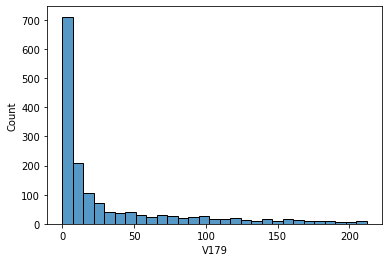

In [14]:
sns.histplot(data=prison_gaurd_ratio_data['V179'])

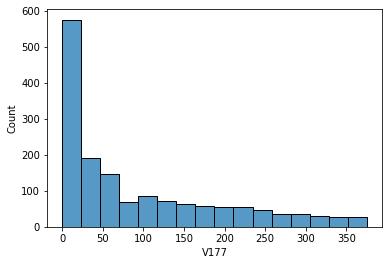

In [15]:
sns.histplot(data=prison_gaurd_ratio_data['V177'])

In [16]:
min(prison_gaurd_ratio_data['V177'])

0.1

In [17]:
prison_gaurd_ratio_data['ratio'] = prison_gaurd_ratio_data.apply(
    lambda row : float(row.V179) / row.V177, axis=1
)
prison_gaurd_ratio_data['ratio'].std()

14.717232158754559

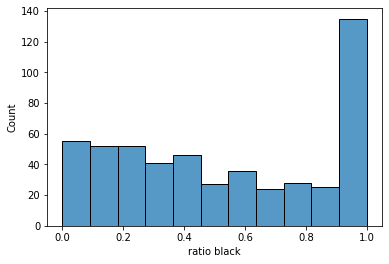

In [18]:
prison_gaurd_ratio_data['V179'] = np.where(prison_gaurd_ratio_data['V179'] == 0, 0.1, prison_gaurd_ratio_data['V179'])
prison_gaurd_ratio_data['ratio black'] = prison_gaurd_ratio_data.apply(
    lambda row : float(row.V177) / row.V179, axis=1
)
sns.histplot(data=prison_gaurd_ratio_data['ratio black'], palette='husl', multiple="stack", binrange=(0, 1))

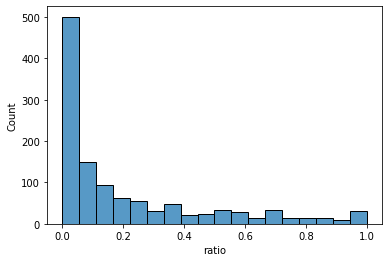

In [19]:
sns.histplot(data=prison_gaurd_ratio_data['ratio'], palette='husl', multiple="stack", binrange=(0, 1))

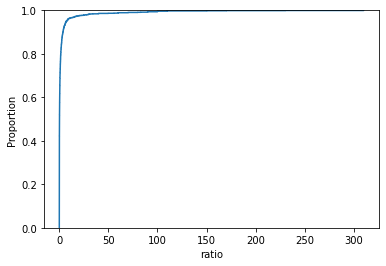

In [20]:
# plotting a boxplot of the prison_guard_ratio_data
sns.ecdfplot(data=prison_gaurd_ratio_data['ratio'],palette='husl')

In [21]:
# find out the counts for Super maximum, maximum, close, or high security level prisons
security_data = prison_data[['V23']]
security_data = security_data.rename({'V23':'security level'}, axis=1)
security_data = security_data[security_data['security level'] != 'Missing']
security_data

,security level
0,Maximum/close/high
1,Maximum/close/high
2,Medium
3,Maximum/close/high
4,Minimum/low
...,...
1816,Minimum/low
1817,Minimum/low
1818,Minimum/low
1819,Minimum/low


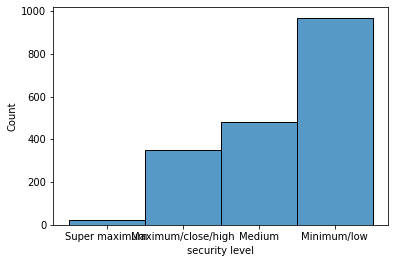

In [22]:
sns.histplot(data=security_data['security level'])

# Intuitive Customer Target List using Richard C. McCorkle's Research 
Before we run any ML models to varify the predictability of the above parameters, let's do an intuitive selection of targeted customers via a blind shot (only using the three paramters above as filter). Recall the following definitions: 
Inefficient prison management have **low black-to-white gaurd ratio**, **high institutional size**, and **high prison security**. \\
Define as below: \\

**low black-to-white gaurd ratio**: ratio below 0.2 is defined as low

**high institutional size**: largest # of inmates above 5 is defined as high institutional size 

**high prison security**: above and including Maximum/ close/ high security is defined as high prison security


In [88]:
# filtering out prisons with low prison security
target = ['Super maximum', 'Maximum/close/high']
intuitive_targetlist = prison_data[prison_data.V23.isin(target)]
intuitive_targetlist

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V39F,...,V203,V204,V204F,V205,V205F,V206,V207,V208,V209,V210,V210S,V211,V212,V212F,V213,V214,V214F,V215,V216,V217,V218,V219,V220,V221,V222,V223,V223S,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V233S,V234,V235
0,010000000070100000000,KILBY CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,P. O. BOX 150,MT. MEIGS,AL,36057.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,Yes,Yes,No,No,No,No,No,No,No,Yes,PRISON INDUSTRY,1,None,0,Don't know,...,Yes,0,Actual,Missing,Don't know,No,Yes,No,No,No,,No,Missing,Actual,No,Missing,Actual,Yes,Yes,Yes,No,No,No,No,No,Yes,NOT SPECIFIED,No,Yes,Yes,Yes,No,No,Yes,Yes,No,Yes,MENTAL HEALTH PROGRAM,No,MONTGOMERY COUNTY
1,010000000070200000000,W C HOLMAN CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,HOLMAN 3700,ATMORE,AL,365033700.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,Yes,0,Actual,Missing,Don't know,Yes,No,No,No,No,,No,Missing,Actual,No,Missing,Actual,No,No,Yes,No,No,Yes,No,No,No,,No,Yes,Yes,Yes,No,No,No,Yes,No,No,,No,ESCAMBIA COUNTY
3,010000000070400000000,JULIA TUTWILER PRISON,,,,MONTGOMERY,AL,36130,8966 US HWY 231 N,WETUMPKA,AL,36092.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Female,Maximum/close/high,,Yes,No,No,Yes,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,Yes,2,Actual,Missing,Don't know,Yes,No,No,No,No,,No,Missing,Actual,No,Missing,Actual,No,No,No,No,No,Yes,No,No,No,,No,Yes,No,Yes,No,No,No,No,Yes,No,,No,ELMORE COUNTY
17,010000000072300000000,WILLIAM DONALDSON CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,100 WARRIOR LANE,BESSEMER,AL,350237299.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,No,0,Actual,Missing,Don't know,No,No,No,No,No,,Yes,Missing,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,,No,Yes,Yes,Yes,No,Yes,No,Yes,No,No,,No,JEFFERSON COUNTY
20,010000000072700000000,ST CLAIR CORRECTIONAL FACILITY,,,,MONTGOMERY,AL,36130,1000 ST. CLAIR ROAD,SPRINGVILLE,AL,351469790.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,Missing,Not applicable,...,No,0,Actual,Missing,Don't know,Yes,Yes,No,No,No,,No,Missing,Actual,No,Missing,Actual,Yes,Yes,Yes,No,No,Yes,No,No,No,,No,No,No,No,No,No,No,No,No,Yes,MENTAL HEALTH CARE SERVICES,No,ST CLAIR COUNTY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,500000000072600000000,COLUMBIA CORRECTIONAL INSTITUTION,,,,PORTAGE,WI,53901,P. O. BOX 950,PORTAGE,WI,539010950.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,830,Estimated,...,Yes,0,Estimated,0,Estimated,Yes,Yes,No,No,No,,No,231,Estimated,No,Missing,Actual,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,,No,No,No,Yes,Yes,Yes,No,No,No,Yes,COGNITIVE INTERVENTION PROGRAM,No,COLUMBIA COUNTY
1801,500000000073900000000,WISCONSIN SECURE PROGRAM FACILITY,,,,BOSCOBEL,WI,53805,P. O. BOX 1000,BOSCOBEL,WI,538050265.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,No,No,No,No,No,No,No,No,No,No,Yes,CONFINEMENT OF HIGH RISK OFFENDERS,1,None,509,Estimated,...,Yes,0,Actual,0,Actual,No,Yes,No,No,No,,No,6,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,No,No,No,No,No,,No,No,No,Yes,No,No,Yes,Yes,No,Yes,COGNITIVE PROGRAMING/ANGER MANAGEMENT,No,GRANT COUNTY
1808,500000000074700000000,STURTEVANT TRANSITIONAL,,,,STURTEVANT,WI,53177,935

In [89]:
# filtering out prisons with low institutional size
intuitive_targetlist['V78'] = intuitive_targetlist['V78'].cat.codes
intuitive_targetlist = intuitive_targetlist[intuitive_targetlist['V78'] >= 600]
intuitive_targetlist['V78']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



17       829
20       796
56      1025
58      1027
60      1002
        ... 
1722     819
1767     710
1772     687
1773     603
1789     804
Name: V78, Length: 217, dtype: int16

In [ ]:
# filtering out prisons with low black-to-white prison guard ratio 
intuitive_targetlist['V179'] = intuitive_targetlist['V179'].cat.codes
intuitive_targetlist['V177'] = intuitive_targetlist['V177'].cat.codes
intuitive_targetlist['V177'] = np.where(intuitive_targetlist['V177'] == 0, 0.1, intuitive_targetlist['V177'])

intuitive_targetlist['ratio'] = intuitive_targetlist.apply(
    lambda row : float(row.V179) / row.V177, axis=1
)

intuitive_targetlist = intuitive_targetlist[intuitive_targetlist['ratio'] <= 0.2]

In [91]:
# filtering out prisons with low institutional size
intuitive_targetlist[['V196']]

,V196
56,1467
58,2195
62,1002
63,1812
64,1292
...,...
1722,1318
1767,253
1772,385
1773,816


In [99]:
tgt = intuitive_targetlist[intuitive_targetlist['V196'] != 'Missing']
tgt['V196'].count()

98

In [41]:
assault_data = prison_data[prison_data['V196'] != 'Missing']
test = prison_data['V2'].apply(lambda x : str(x))
test.str.contains('CALIFORNIA REHABILITATION CENTER').any()

True

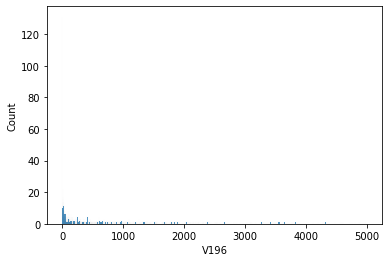

In [86]:
sns.histplot(data=assault_data['V196'], palette='husl', multiple="stack", binrange=(0, 5000))

Let's try to understand more about our target customer list


In [98]:
intuitive_targetlist

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V39F,...,V204,V204F,V205,V205F,V206,V207,V208,V209,V210,V210S,V211,V212,V212F,V213,V214,V214F,V215,V216,V217,V218,V219,V220,V221,V222,V223,V223S,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V233S,V234,V235,ratio
56,030000000070100000000,ASPC - FLORENCE,,,,PHOENIX,AZ,85007,P. O. BOX 629,FLORENCE,AZ,852320629.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,,1,None,3690,Actual,...,0,Actual,0,Actual,Yes,Yes,Yes,Yes,No,,No,2187,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,,No,PINAL COUNTY,0.079096
58,030000000071000000000,ASPC - TUSCON,,,,PHOENIX,AZ,85007,10000 S WILMOT ROAD,TUCSON,AZ,857344400.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Both,Maximum/close/high,,Yes,Yes,No,No,No,No,No,No,No,No,No,,1,Less than 50% of the inmates,4230,Actual,...,0,Actual,0,Actual,Yes,Yes,No,Yes,No,,No,2545,Actual,Yes,32,Actual,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,,No,PIMA COUNTY,0.108635
62,030000000071900000000,ASPC - WINSLOW,,,,PHOENIX,AZ,85022,2100 S. HWY 87,WINSLOW,AZ,86047.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,Yes,No,No,No,No,No,No,No,No,No,,1,None,1802,Actual,...,0,Actual,0,Actual,Yes,Yes,No,Yes,No,,No,1094,Actual,No,Missing,Actual,Yes,Yes,Yes,No,No,Yes,No,No,No,,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,,No,NAVAJO COUNTY,0.037209
63,030000000072100000000,ASPC - YUMA,,,,PHOENIX,AZ,85007,P. O. BOX 13004,YUMA,AZ,853663004.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,Yes,No,No,No,No,No,No,No,No,No,,1,None,2120,Actual,...,0,Actual,0,Actual,Yes,Yes,No,Yes,No,,No,1196,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,,No,YUMA COUNTY,0.117188
64,030000000072300000000,ASPC - EYMAN,,,,PHOENIX,AZ,85007,P. O. BOX 3500,FLORENCE,AZ,852323500.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Super maximum,,Yes,Yes,No,No,Yes,No,No,No,No,No,No,,1,None,4600,Actual,...,Missing,Actual,0,Actual,Yes,Yes,No,No,No,,No,1862,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,HEPATITIS PEER GROUP,No,PINAL COUNTY,0.144772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,480000000070300000000,WASHINGTON CORRECTIONAL CENTER,,,,SHELTON,WA,98584,P. O. BOX 900,SHELTON,WA,98584.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,Yes,Yes,Yes,No,No,Yes,Yes,No,No,,3,None,1106,Actual,...,0,Actual,0,Actual,Yes,Yes,No,No,No,,No,Missing,Don't know,No,Missing,Actual,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,,No,No,No,No,No,No,Yes,Yes,Yes,No,,No,OKANOGAN COUNTY,0.073944
1767,496039666070800000000,USP HAZELTON & CAMP,,,,BRUCETON MILLS,WV,26525,SKY VIEW DRIVE,BRUCETON MILLS,WV,26525.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,Fed,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,Less than 50% of the inmates,1088,Actual,...,0,Actual,0,Actual,Yes,Yes,No,No,No,,No,Missing,Actual,No,Missing,Actual,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,,No,,0.057803
1772,500000000070100000000,WAUPUN CORRECTIONAL INSTITUTION,,,,WAUPUN,WI,53963,P. O. BOX 351,WAUPUN,WI,539630351.0,Missing,Missing,Missing,Missing,Missing,Missing,Missing,,St,Male,Maximum/close/high,,Yes,No,No,No,No,No,No,No,No,No,No,,1,None,1240,Estimated,...,0,Actual,0,Actual,Yes,Yes,No,No,Yes,"EDUCATION TUTORING, COMMUNITY SERVICE PROJECTS",No,542,Ac

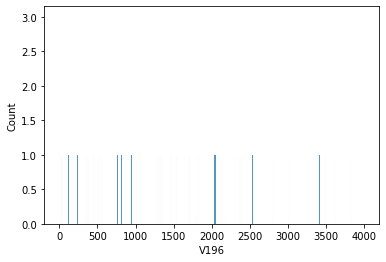

In [95]:
sns.histplot(data=tgt['V196'], palette='husl', multiple="stack", binrange=(0, 4000))

In [100]:
# find the assaults per inmate 
tgt['V196'] = tgt['V196'].cat.codes 
tgt['assault per inmate'] = tgt.apply(
    lambda row : row.V196 / row.V78, axis=1
)
tgt['assault per inmate']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



56      0.591220
58      0.689387
62      0.605263
63      0.688866
64      0.548887
          ...   
1722    0.698413
1767    0.295775
1772    0.420670
1773    0.759536
1789    0.708955
Name: assault per inmate, Length: 98, dtype: float64

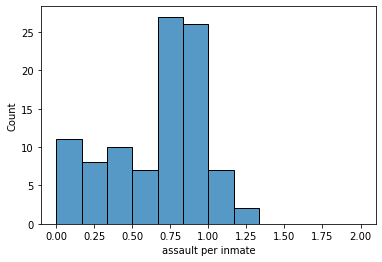

In [115]:
sns.histplot(data=tgt['assault per inmate'], palette='husl', multiple="stack", binrange=(0, 2))

In [108]:
# let's compute the distribution of assault per inmate for the population 
prison_data['V196'] = prison_data['V196'].cat.codes 
prison_data['V78'] = prison_data['V78'].cat.codes 

In [109]:
prison_data['V196'].dtypes

dtype('int16')

In [110]:
prison_data['V78'].dtypes

dtype('int16')

In [111]:
prison_data['V78'] = np.where(prison_data['V78'] == 0, 0.1, prison_data['V78'])
prison_data['assault per inmate'] = prison_data.apply(
    lambda row : row.V196 / row.V78, axis=1
)
prison_data['assault per inmate']


0       0.558659
1       0.931338
2       0.503628
3       0.921305
4       1.065041
          ...   
1816    0.120370
1817    0.250000
1818    0.486339
1819    0.517241
1820    0.634146
Name: assault per inmate, Length: 1821, dtype: float64

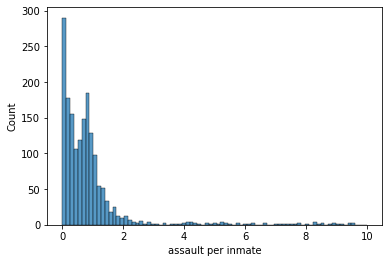

In [120]:
sns.histplot(data=prison_data['assault per inmate'], palette='husl', multiple="stack", binrange=(0, 10))

In [121]:
# let's save this target list in a csv file
tgt.to_csv('/content/prison_market_analysis_data/target_clients.csv')

#Multiple Regression Model
Now, we'll run a simple **multiple regression** model on our dataset. We want to predict the **# of assaults per inmate** based on different **PCA paramters**, and we will **analyze the rms** of the model in the end. 
